In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

In [2]:
#dataset and its description is available at: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

## Data Preprocessing

In [3]:
#quick look at dataset structure
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


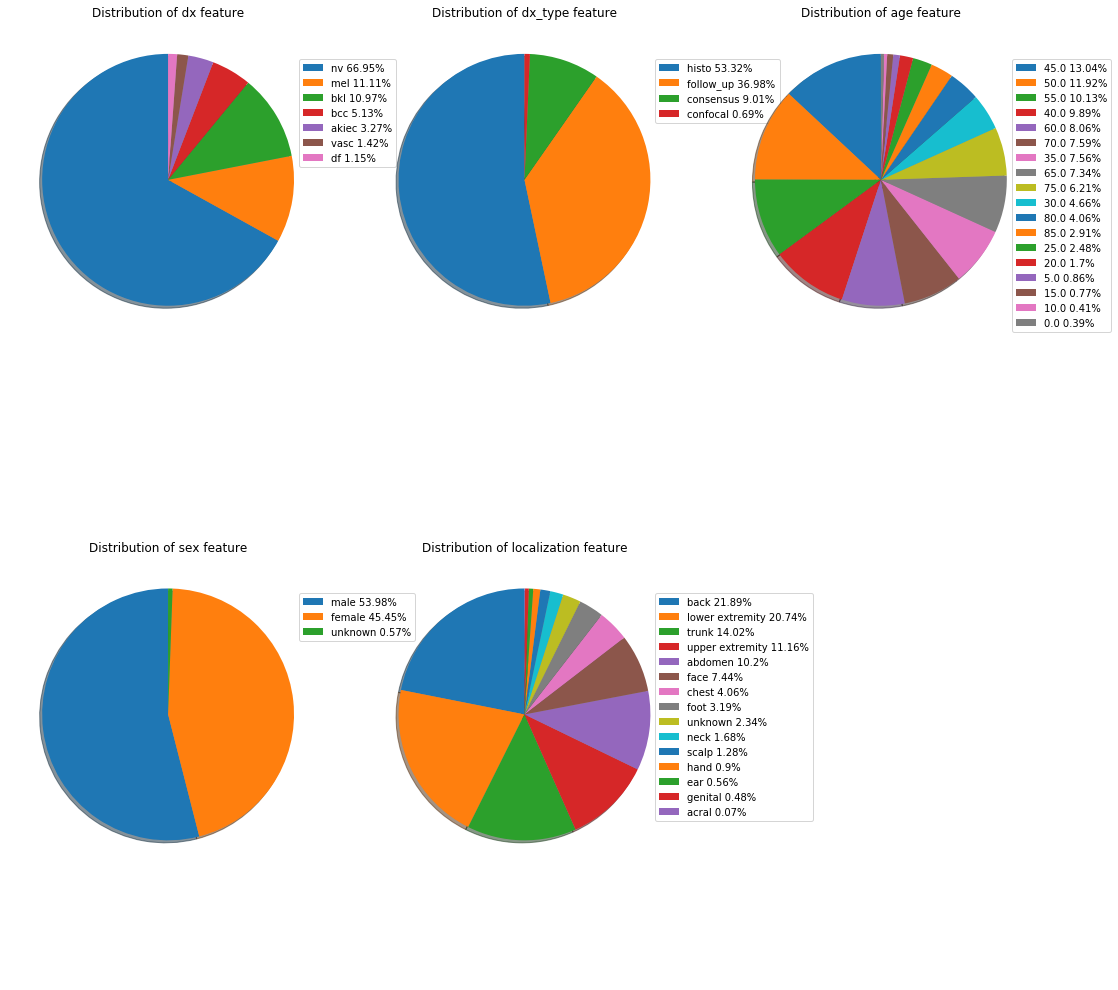

In [4]:
# features distribution visualization
fig, axs = plt.subplots(2, 3, figsize=(15,15))
fig.tight_layout()
axs = axs.flatten()
for num, col in enumerate(df.columns[2:]):
    total =sum(list(df[col].value_counts()))
    ratio = [ str(round(x/total*100, 2)) for x in list(df[col].value_counts())]
    canc_labels = list(df[col].value_counts().index.astype('str'))
    labels = []
    for i in range(len(ratio)):
        labels.append(canc_labels[i] + ' ' + ratio[i] + '%')
    axs[num].pie(ratio,shadow=True, startangle=90)
    axs[num].legend(labels, loc='upper left', bbox_to_anchor=(0.9, 0.9))
    axs[num].set_title(f'Distribution of {col} feature')
axs[-1].axis('off');    

In [5]:
# we use only lesion_ids that have not duplicate image_ids for validation set 
df_temp = df.groupby('lesion_id').count()
idxs = df['lesion_id'].isin(df_temp[df_temp['image_id'] == 1].index)
df_temp = df[idxs].reset_index(drop=True)
_, df_val = train_test_split(df_temp, test_size=1000, random_state=13, stratify=df_temp['dx'])
del df_temp

In [6]:
# remove all validation set instances from original data set to create train set
df_train = pd.concat([df,df_val]).drop_duplicates(keep=False)

In [7]:
# create folder structure for images
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

lesion_list = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
dir_list = [train_dir, val_dir]

for tr_val_dir in dir_list:
    for lesion in lesion_list:
        os.mkdir(os.path.join(tr_val_dir, lesion))

In [8]:
# set image_id as index in df
df.set_index('image_id', inplace=True)

In [9]:
# lists of images 
folder_1 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')
folder_2 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')

# copy each image into corresponding folder
img_tr_val_list = [[list(df_train['image_id']), train_dir], [list(df_val['image_id']), val_dir]]
for img_list in img_tr_val_list:
    for image in img_list[0]:
        fname = image + '.jpg'
        label = df.loc[image,'dx']

        if fname in folder_1:
            src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', fname)
            dst = os.path.join(img_list[1], label, fname)
            shutil.copyfile(src, dst)

        if fname in folder_2:
            src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', fname)
            dst = os.path.join(img_list[1], label, fname)
            shutil.copyfile(src, dst)

In [10]:
# classes to augment
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    # create temporary folder for augmentation
    aug_dir = 'aug_dir'
    os.mkdir('aug_dir')
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)
    img_list = os.listdir('base_dir/train_dir/' + item)
    
    # copy images into temporary dir
    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + item, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = 'base_dir/train_dir/' + item
    # create image generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path, save_to_dir=save_path, save_format='jpg',
                                              target_size=(224,224), batch_size=batch_size)
    # to balance classes we want each class to have about 6000 images(major class 'nv' have 5954 images)
    num_aug_images_wanted = 6000 
    
    num_files = len(os.listdir(img_dir))
    num_batches = (num_aug_images_wanted-num_files) // batch_size + 1
    
    # generate augmented images for current class
    for i in range(num_batches):
        imgs, labels = next(aug_datagen)
    # delete temp folder    
    shutil.rmtree('aug_dir')

Found 1071 images belonging to 1 classes.
Found 1019 images belonging to 1 classes.
Found 482 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 108 images belonging to 1 classes.


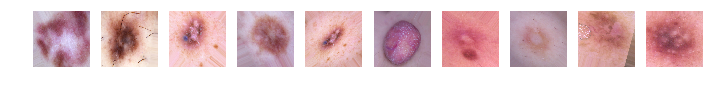

In [11]:
# plots last generated batch of images 
def plot_images(ims, figsize=(12,6), rows=5, interp=False, titles=None): 
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(cols):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plot_images(imgs)

## Model

In [12]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
batch_size = 10
image_size = 224

train_steps = num_train_samples // batch_size 
val_steps = num_val_samples // batch_size 

In [13]:
# create train/val batch generator
datagen = ImageDataGenerator(preprocessing_function= tensorflow.keras.applications.mobilenet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1, shuffle=False)

Found 39248 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.


In [14]:
#MobileNets are a family of neural network architectures released by Google to be used on machines with limited computing power,
#like mobile devices. They strive to provide state of the art accuracy, while requiring as little memory and computing power as possible.
#This makes them a very fast family of networks to use for image processing.

#MobileNets achieve this performance by reducing dramatically the number of learnable parameters, which also makes them faster and easier
#to train compared to more traditional networks.

mobile = tensorflow.keras.applications.mobilenet_v2.MobileNetV2()

14540800/14536120 [==============================] - 1s 0us/step


In [15]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
# change the number of units in last dense block to match the number of classes we have
x = mobile.layers[-2].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [18]:
# we train only last 33 layers
for layer in model.layers[:-32]:
    layer.trainable = False

In [19]:
# wrap top_k_categorical_accuracy for k=2 and k=3
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [20]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

## Training and evaluation

In [21]:
# make model more sensitive to Melanoma
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel 
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [22]:
# save model as model.h5
filepath = "model.h5"
# save model with the best val_top_3_accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
# learning rate sheduler
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

#its history.history attribute is a record of training loss values and metrics values at successive epochs,
#as well as validation loss values and validation metrics values (if applicable)
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches, validation_steps=val_steps,
                              epochs=30, verbose=1,
                              callbacks=callbacks_list)

Train for 901 steps, validate for 100 steps
Epoch 1/30
900/901 [============================>.] - ETA: 0s - loss: 1.4214 - categorical_accuracy: 0.5634 - top_2_accuracy: 0.7694 - top_3_accuracy: 0.8844
Epoch 00001: val_top_3_accuracy improved from -inf to 0.54400, saving model to model.h5
901/901 [==============================] - 64s 71ms/step - loss: 1.4209 - categorical_accuracy: 0.5636 - top_2_accuracy: 0.7695 - top_3_accuracy: 0.8844 - val_loss: 6.4033 - val_categorical_accuracy: 0.1050 - val_top_2_accuracy: 0.3580 - val_top_3_accuracy: 0.5440
Epoch 2/30
900/901 [============================>.] - ETA: 0s - loss: 1.0980 - categorical_accuracy: 0.6647 - top_2_accuracy: 0.8505 - top_3_accuracy: 0.9332
Epoch 00002: val_top_3_accuracy improved from 0.54400 to 0.91400, saving model to model.h5
901/901 [==============================] - 56s 62ms/step - loss: 1.0977 - categorical_accuracy: 0.6649 - top_2_accuracy: 0.8506 - top_3_accuracy: 0.9332 - val_loss: 1.7927 - val_categorical_accura

In [23]:
# print values of metrics
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                         steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.6428900673031593
val_cat_acc: 0.81
val_top_2_acc: 0.908
val_top_3_acc: 0.955


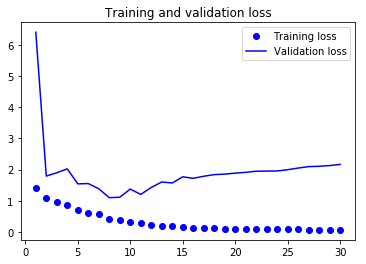

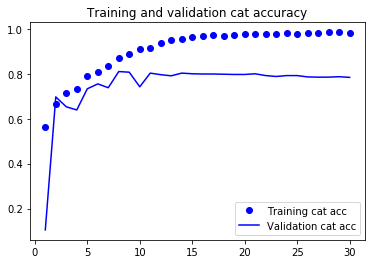

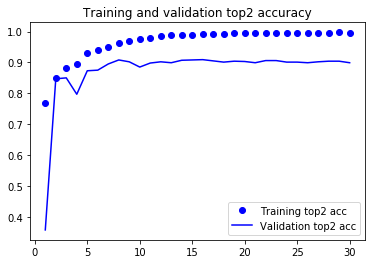

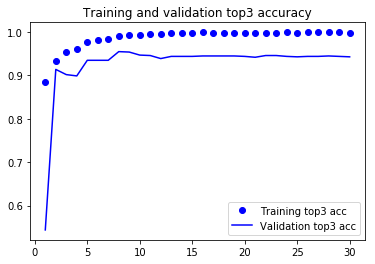

In [24]:
# plot learning curves
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend();

In [25]:
# labels of test images
test_labels = test_batches.classes

predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

1000/1000 [==============================] - 16s 16ms/step


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 13   2   0   1   0  11   0]
 [  3   9   0   0   0  20   0]
 [ 18   7   8   0   0  47   0]
 [  0   1   0   2   0   4   0]
 [ 11   0   0   4   2  25   0]
 [ 12   4   1  14   1 769   0]
 [  0   2   0   0   0   2   7]]


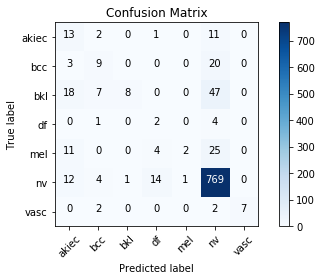

In [27]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [28]:
# print classification report
print(classification_report(test_batches.classes, np.argmax(predictions, axis=1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

       akiec       0.23      0.48      0.31        27
         bcc       0.36      0.28      0.32        32
         bkl       0.89      0.10      0.18        80
          df       0.10      0.29      0.14         7
         mel       0.67      0.05      0.09        42
          nv       0.88      0.96      0.92       801
        vasc       1.00      0.64      0.78        11

    accuracy                           0.81      1000
   macro avg       0.59      0.40      0.39      1000
weighted avg       0.83      0.81      0.78      1000



## Convert model from Keras to Tensorflow.js

In [29]:
pip install tensorflowjs

     |████████████████████████████████| 61kB 1.4MB/s 
     |████████████████████████████████| 104.6MB 133kB/s 
     |████████████████████████████████| 256kB 39.2MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32853 sha256=9a0f77f64903adc91b8822184fd35708a52b4cf2a7d082cf5618fd56648b1804
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: jupyter-console 6.0.0 has requirement prompt_toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
ERROR: ipython 7.10.2 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
  Found existing installation: prompt-toolkit 2.0.10
    Uninstalling prompt-toolkit-2.0.10:
      Successfully uninstalled prompt-toolkit-2.0.10
Note: you may need to restart the kernel to use updated packages.


In [30]:
#create a dir to store model files
os.mkdir('tfjs_dir')

import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_dir')

In [31]:
# only for Kaggle kernel, it allows a max of 500 files to be saved
shutil.rmtree('base_dir')